**Python Version Requirement:** Python 3.6

In [190]:
import requests
import sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr
import os
import eli5
import json

In [97]:
pd.set_option(
    'display.float_format',
    lambda x: '%.5f' % x
)

In [201]:
FEATURE_VECTOR = ['query_num_of_columns',
                  'query_num_of_rows',
                  'query_row_column_ratio',
                  'query_max_skewness',
                  'query_max_kurtosis',
                  'query_max_unique',
                  'candidate_num_of_columns',
                  'candidate_num_rows',
                  'candidate_row_column_ratio',
                  'candidate_max_skewness',
                  'candidate_max_kurtosis',
                  'candidate_max_unique',
                  'query_target_max_pearson',
                  'query_target_max_spearman',
                  'query_target_max_covariance',
                  'query_target_max_mutual_info',
                  'candidate_target_max_pearson',
                  'candidate_target_max_spearman',
                  'candidate_target_max_covariance',
                  'candidate_target_max_mutual_info',
                  'max_pearson_difference',
                  'containment_fraction']
GAIN_COLUMN_NAME = 'gain_in_r2_score'

In [199]:
def print_df(df):
    """Prints entire pandas dataframe.
    """
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.expand_frame_repr', False,
                           'display.max_colwidth', 100):
        print(df)

In [191]:
def get_dataset_name(id_):
    """Connects to Datamart to get the dataset name, given the dataset id.
    """
    
    response = requests.get(
        'http://localhost:8002/metadata/%s'%id_,
    )
    response.raise_for_status()
    
    return json.loads(response.text)['metadata']['name']

In [145]:
def create_model(alpha, training_filename, feature_vector, gain_column):
    """This functions builds a classifier based on the training data.
    """
    
    training_data = pd.read_csv(training_filename)
    training_data['class'] = ['gain' if row[gain_column] > alpha else 'loss'
                              for index, row in training_data.iterrows()]
    X_train = training_data[feature_vector]
    y_train = training_data['class']
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    return clf

In [192]:
def predict_class_for_features(classifier, test_filename, feature_vector):

    test_data = pd.read_csv(test_filename)
    # avoiding overflow
    for col in test_data.select_dtypes([np.number]).columns:
        test_data = test_data[test_data[col] < np.finfo(np.float32).max]
    test_data.reset_index(inplace=True)
    X_test = test_data[feature_vector]
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    predicted_classes = classifier.predict(X_test)
    predicted_proba = classifier.predict_proba(X_test)
    
    explanations = list()
    for index, row in X_test.iterrows():
        explanations.append(eli5.explain_prediction_df(classifier, X_test.iloc[index]))
    
    test_data['class'] = predicted_classes
    test_data['candidate_id'] = test_data['candidate'].apply(
        lambda x: os.path.basename(x)
    )
    test_data['candidate_name'] = test_data['candidate_id'].apply(
        lambda x: get_dataset_name(x[:x.find('_')])
    )
    test_data.rename(columns={'containment_fraction': 'cf'}, inplace=True)
    test_data.rename(columns={'gain_in_r2_score': 'g_r2'}, inplace=True)
    
    probabilities = pd.DataFrame(predicted_proba, columns=list(classifier.classes_))
    test_data['p(gain)'] = probabilities['gain']
    test_data['p(loss)'] = probabilities['loss']
    
    new_test_data = test_data[
        ['candidate_name', 'candidate_id', 'cf', 'g_r2', 'class', 'p(gain)', 'p(loss)']
    ].sort_values('g_r2', ascending=False)
    new_test_data.reset_index(drop=True, inplace=True)
    
    return (new_test_data, explanations)

In [187]:
def compute_precision_recall(df):
    
    tp_vals = list()
    index_tp = list()
    fp_vals = list()
    index_fp = list()
    tn_vals = list()
    index_tn = list()
    fn_vals = list()
    index_fn = list()
    
    for index, row in df.iterrows():
        if row['g_r2'] > 0 and row['class'] == 'gain':
            tp_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_tp.append(index)
        elif row['g_r2'] > 0 and row['class'] == 'loss':
            fn_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_fn.append(index)
        elif row['g_r2'] < 0 and row['class'] == 'gain':
            fp_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_fp.append(index)
        else:
            tn_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_tn.append(index)
            
    tp = len(tp_vals)
    fn = len(fn_vals)
    fp = len(fp_vals)
    tn = len(tn_vals)
            
    columns = ['name', 'g_r2', 'p(gain)', 'cf']
    tp_df = pd.DataFrame(tp_vals, columns=columns, index=index_tp)
    fn_df = pd.DataFrame(fn_vals, columns=columns, index=index_fn)
    fp_df = pd.DataFrame(fp_vals, columns=columns, index=index_fp)
    tn_df = pd.DataFrame(tn_vals, columns=columns, index=index_tn)
            
    print("-- TP:", tp)
    print_df(tp_df)
    print('')
    print("-- TN:", tn)
    print_df(tn_df)
    print('')
    print("-- FP:", fp)
    print_df(fp_df)
    print('')
    print("-- FN:", fn)
    print_df(fn_df)
    print('')

    precision = tp / (tp + fp) if tp + fp > 0 else np.nan
    recall = tp / (tp + fn) if tp + fn > 0 else np.nan
    
    print('Precision: %.4f\nRecall: %.4f'%(precision, recall))

In [7]:
def compute_pearson(df, col_1, col_2):
    return pearsonr(df[col_1], df[col_2])[0]

In [194]:
rf_classifier = create_model(
    alpha=0,
    training_filename='../data/training-for-model.csv',
    feature_vector=FEATURE_VECTOR,
    gain_column=GAIN_COLUMN_NAME
)

/opt/anaconda3/envs/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/python-3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## NY Taxi and Vehicle Collision Problem

In [195]:
taxi_vehicle_collision_classes, taxi_vehicle_collision_explanations = predict_class_for_features(
    rf_classifier,
    'taxi-vehicle-collision-records-features',
    FEATURE_VECTOR
)

/opt/anaconda3/envs/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [200]:
compute_precision_recall(taxi_vehicle_collision_classes)

-- TP: 20
                                                                        name    g_r2  p(gain)      cf
0                                                           DHS Daily Report 4.43722  0.50000 0.97238
1               Performance Metrics - Buildings - Time to Issue Easy Permits 4.24356  0.50000 0.14365
2               Performance Metrics - Buildings - Time to Issue Easy Permits 4.24356  0.50000 0.14365
5                                                  Daily Weather Data for NY 2.69791  0.70000 1.00000
6                                    CTA - Ridership - Daily Boarding Totals 2.42632  0.50000 1.00000
7              Performance Metrics - Buildings - Time To Issue Green Permits 2.09037  0.70000 0.14365
8              Performance Metrics - Buildings - Time To Issue Green Permits 2.09037  0.70000 0.14365
9                          Lottery Powerball Winning Numbers: Beginning 2010 1.89893  0.60000 0.24862
10                          Lottery NY Lotto Winning Numbers: Beginning 

In [76]:
# Pearson between containment fraction and gain in R2
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'g_r2')

0.30926206685429014

In [77]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'p(gain)')

0.057036178367895124

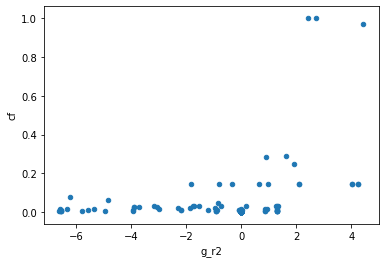

In [86]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='cf', )

In [78]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'g_r2', 'p(gain)')

-0.058055263482290224

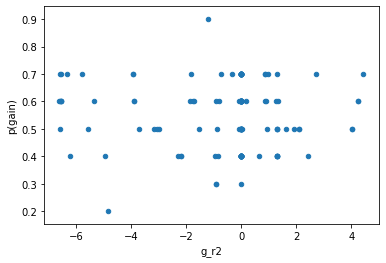

In [87]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='p(gain)', )

## College Debt

In [15]:
college_debt_classes = predict_class_for_features(
    rf_classifier,
    'college-debt-records-features',
    FEATURE_VECTOR
)

In [17]:
compute_precision_recall(college_debt_classes)

-- TP: 2
   . 0		0.808117	0.800000	1.000000
   . 1		0.727736	0.700000	1.000000
-- TN: 0
-- FP: 0
-- FN: 0
Precision: 1.0000
Recall: 1.0000


In [18]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes, 'cf', 'g_r2')

/opt/anaconda3/envs/python-3.6/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


nan

In [19]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes, 'cf', 'p(gain)')

nan

In [20]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes, 'g_r2', 'p(gain)')

1.0

## Poverty Estimation

In [21]:
poverty_estimation_classes = predict_class_for_features(
    rf_classifier,
    'poverty-estimation-records-features',
    FEATURE_VECTOR
)

In [23]:
compute_precision_recall(poverty_estimation_classes)

-- TP: 1
   . 0		0.028248	0.600000	1.000000
-- TN: 7
   . 1		-0.290706	0.400000	0.001276
   . 2		-0.299034	0.300000	0.001594
   . 3		-0.299140	0.300000	0.001276
   . 4		-0.299818	0.200000	0.000319
   . 5		-0.301699	0.300000	0.001276
   . 6		-0.304692	0.300000	0.000638
   . 7		-0.310184	0.300000	0.001276
-- FP: 1
   . 8		-0.317801	0.600000	0.001276
-- FN: 0
Precision: 0.5000
Recall: 1.0000


In [24]:
# Pearson between containment fraction and gain in R2
compute_pearson(poverty_estimation_classes, 'cf', 'g_r2')

0.997610183234824

In [25]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'cf', 'p(gain)')

0.6190989311094166

In [26]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'g_r2', 'p(gain)')

0.5887713733160523